# Deep Convoluted Neural Network (DCNN) applied to the Malignant vs. Benign Skin Tumor dataset on Kaggle
### Residual network was used to incorporate skips connections to train and backpropogate through the datasets quicker
### Code adapted from examples by Claudio Fanconi (https://www.kaggle.com/fanconic/starter-skin-cancer-malignant-vs-benign) and Dr Simon Denman

In [1]:
# Required Libraries

# Data Manipulation
import os
import datetime
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

# DCNN functions/variables
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras import activations
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Setting up the Data

In [2]:
# File folder locations for os functions
benign_train_folder = './archive/train/benign'
malignant_train_folder = './archive/train/malignant'
benign_test_folder = './archive/test/benign'
malignant_test_folder = './archive/test/malignant'

# Helper function, to convert files to RGB np arrays
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load training images
benign_imgs = [read(os.path.join(benign_train_folder, filename)) for filename in os.listdir(benign_train_folder)]
benign_x_train = np.array(benign_imgs, dtype='uint8')
malignant_imgs = [read(os.path.join(malignant_train_folder, filename)) for filename in os.listdir(malignant_train_folder)]
malignant_x_train = np.array(malignant_imgs, dtype='uint8')

# Load testing images
benign_imgs = [read(os.path.join(benign_test_folder, filename)) for filename in os.listdir(benign_test_folder)] # Adds them to the above
benign_x_test = np.array(benign_imgs, dtype='uint8')
malignant_imgs = [read(os.path.join(malignant_test_folder, filename )) for filename in os.listdir(malignant_test_folder)] # Adds them to the above
malignant_x_test = np.array(malignant_imgs, dtype='uint8')

# Labels for all datasets
# Use '0' to indicate benign and '1' to indicate malignant
benign_y_train = np.zeros(benign_x_train.shape[0])
malignant_y_train = np.ones(malignant_x_train.shape[0])
benign_y_test = np.zeros(benign_x_test.shape[0])
malignant_y_test = np.ones(malignant_x_test.shape[0])

# Merge malignant and benign into single train and test datasets
train_x = np.concatenate((benign_x_train, malignant_x_train), axis=0)
train_y = np.concatenate((benign_y_train, malignant_y_train), axis=0)
test_x = np.concatenate((benign_x_test, malignant_x_test), axis=0)
test_y = np.concatenate((benign_y_test, malignant_y_test), axis=0)

# Shuffle data to test properly
train_seed = np.arange(train_x.shape[0])
np.random.shuffle(train_seed)
train_x = train_x[train_seed]
train_y = train_y[train_seed]

test_seed = np.arange(test_x.shape[0])
np.random.shuffle(test_seed)
test_x = test_x[test_seed]
test_y = test_y[test_seed]

## Visualise the Dataset
### Import to both see some samples of the dataset to see if they have been affected by the loadign process, and also the distribution of the classes to determine if there is any class imbalance

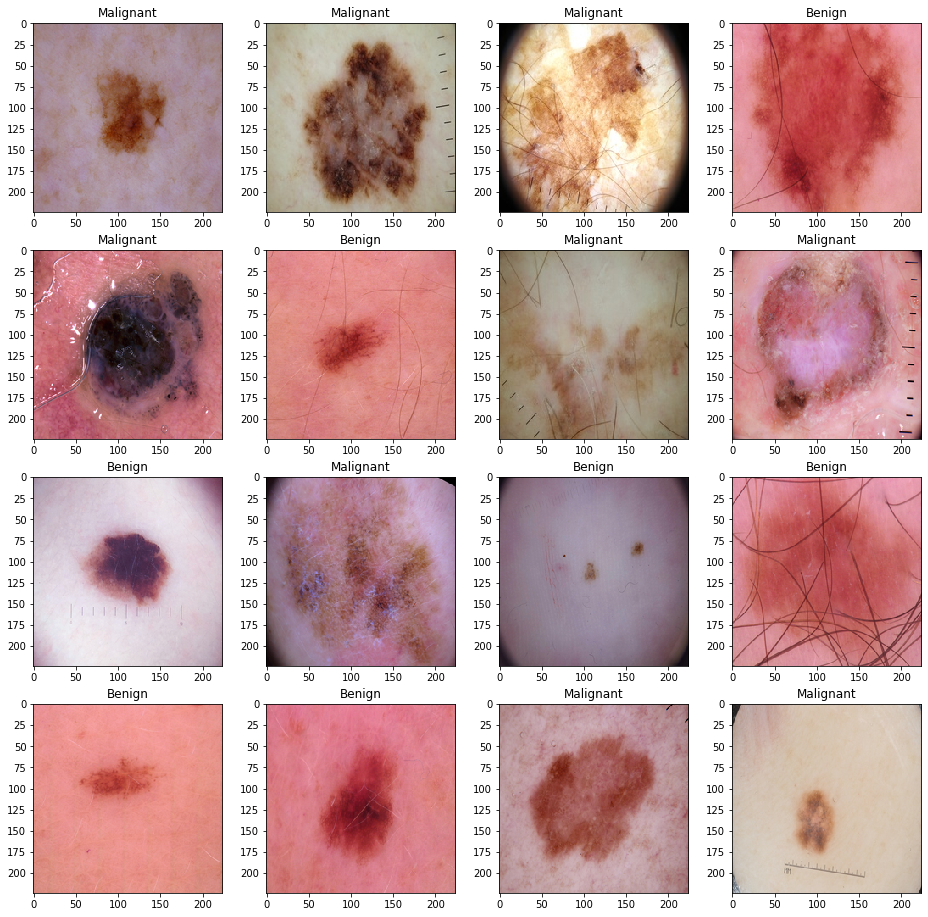

In [4]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if train_y[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(train_x[i], interpolation='nearest')
plt.show()

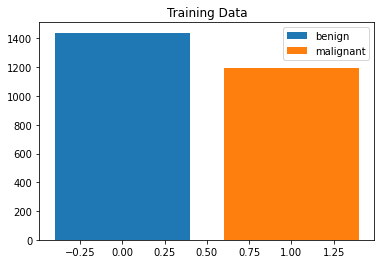

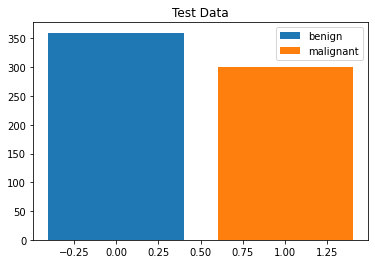

In [17]:
plt.bar(0, train_y[np.where(train_y == 0)].shape[0], label = 'benign')
plt.bar(1, train_y[np.where(train_y == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, test_y[np.where(test_y == 0)].shape[0], label = 'benign')
plt.bar(1, test_y[np.where(test_y == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()

# Indicates that there are slightly more samples of benign than malignant in both datasets


## Evaluation Functions
### Functions to evaluate the total loss and accuracy of the model against the test data, as well as the progress of the model's training

In [3]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test)
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)
    
def plot_training(history):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend(); 

## Helper Functions for constructing the network
### Resnet_layer
#### 2D Convolution-Batch Normalisation-Activation stack builder
#### Inputs
- Input tensor
- Number of filters
- Square kernel dimensions
- Square stride dimensions
- Activiation name
- Boolean to decide if batch normalisation is used
- Boolean which indicates if the current layering stack is Convolutional layer => Batch Normalisation => Activation or Batch Normalization => Activation => Convolutional layer
#### Returns
- A tensor as an input to the next layer

### Resnet
#### Stacks of 2 x (3 x 3) Conv2D-BN-ReLU 
#### Last ReLU is after the shortcut connection.
#### At the beginning of each stage, the feature map size is halved (downsampled) by a convolutional layer with strides=2, while the number of filters is doubled. 
#### Within each stage, the layers have the same number filters and the same number of filters.
#### Inputs
- The input tensor
- Number of filters in each stage, length of list determines the number of stages
- Number of residual blocks per stage
- Size of the average pooling at the end
#### Returns
- Output after global average pooling and flatten, ready for output

### Resnet_v2
#### Alternative model structure to Resnet, which uses Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as bottleneck layer
#### First shortcut connection per layer is 1 x 1 Conv2D.
#### Second and onwards shortcut connection is identity.
#### At the beginning of each stage, the feature map size is halved (downsampled) by a convolutional layer with strides=2, while the number of filter maps is doubled. 
#### Within each stage, the layers have the same number filters and the same filter map sizes.
#### Inputs
- The input tensor
- Number of filters in each stage, length of list determines number of stages
- Number of residual blocks per stage
- Size of the average pooling at the end
#### Returns
- Output after global average pooling and flatten, ready for output

In [4]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet(inputs, filters, num_res_blocks, pool_size):
    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)

    return y

    # Different variation of ResNet build function, to test to see if it yields better results

def resnet_v2(inputs, filters, num_res_blocks, pool_size):
    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

In [29]:
# Compile the network
inputs = Input(shape=(224,224,3,), name='img')
x = resnet(inputs, [16,32], 1, 14) # Initial standard hyperparameters for testing
output = Dense(2)(x) # Only two outputs
resnet_1_model = keras.Model(inputs=inputs, outputs=output, name='resnet_1_model')

In [30]:
resnet_1_model.summary()

Model: "resnet_1_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 224, 224, 16) 64          conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 224, 224, 16) 0           batch_normalization_20[0][0]     
_____________________________________________________________________________________

In [32]:
# First trained model
resnet_1_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
history = resnet_1_model.fit(train_x, train_y, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
33/33 [==============================] - 111s 3s/step - loss: 0.7125 - accuracy: 0.7093 - val_loss: 0.5812 - val_accuracy: 0.7045
Epoch 2/10
33/33 [==============================] - 110s 3s/step - loss: 0.4838 - accuracy: 0.7809 - val_loss: 0.5448 - val_accuracy: 0.7348
Epoch 3/10
33/33 [==============================] - 111s 3s/step - loss: 0.4401 - accuracy: 0.7904 - val_loss: 1.2602 - val_accuracy: 0.5833
Epoch 4/10
33/33 [==============================] - 112s 3s/step - loss: 0.4223 - accuracy: 0.8113 - val_loss: 1.4274 - val_accuracy: 0.4621
Epoch 5/10
33/33 [==============================] - 112s 3s/step - loss: 0.3968 - accuracy: 0.8160 - val_loss: 1.2146 - val_accuracy: 0.6875
Epoch 6/10
33/33 [==============================] - 112s 3s/step - loss: 0.3818 - accuracy: 0.8279 - val_loss: 0.7974 - val_accuracy: 0.7443
Epoch 7/10
33/33 [==============================] - 112s 3s/step - loss: 0.3698 - accuracy: 0.8383 - val_loss: 0.4838 - val_accuracy: 0.8144
Epoch 8/10
33

21/21 - 5s - loss: 0.7089 - accuracy: 0.7636
Test loss: 0.7089154124259949
Test accuracy: 0.7636363506317139


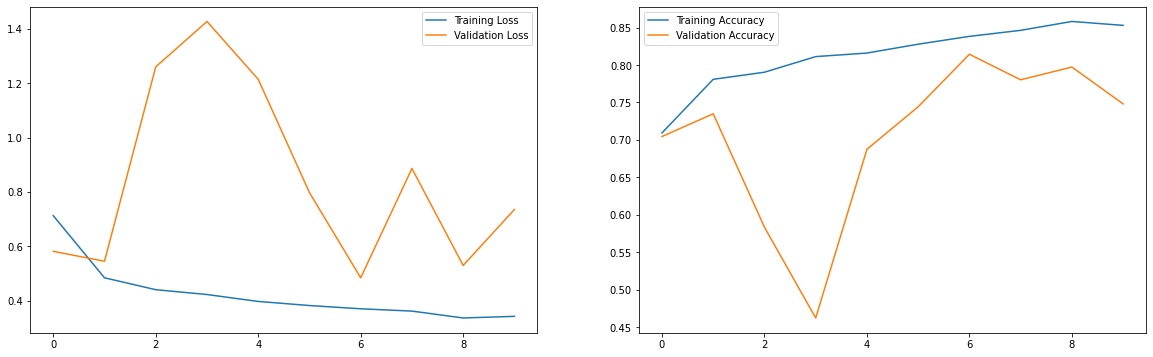

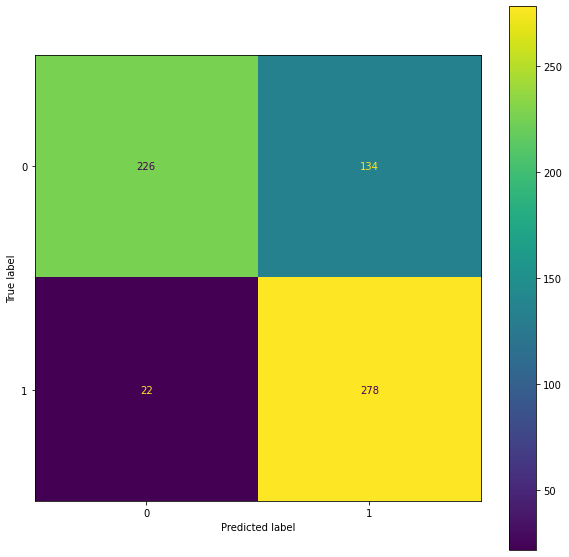

In [35]:
# Show results graphically
plot_training(history)
eval_model(resnet_1_model, test_x, test_y)

In [5]:
# Experiment with different hyperparameters

x = resnet(inputs, [16,32,64], 2, 7)
# Increase the number of filters, double residual blocks, halve pooling
resnet_2_model = keras.Model(inputs=inputs, outputs=output, name='resnet_2_model')

In [6]:
resnet_2_model.summary()

Model: "resnet_2_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [7]:
# Second trained model
resnet_2_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
history = resnet_2_model.fit(train_x, train_y, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
33/33 [==============================] - 249s 7s/step - loss: 1.6523 - accuracy: 0.7032 - val_loss: 30.5233 - val_accuracy: 0.4602
Epoch 2/10
33/33 [==============================] - 241s 7s/step - loss: 0.6739 - accuracy: 0.7587 - val_loss: 7.6084 - val_accuracy: 0.5360
Epoch 3/10
33/33 [==============================] - 244s 7s/step - loss: 0.6144 - accuracy: 0.7691 - val_loss: 6.6197 - val_accuracy: 0.5170
Epoch 4/10
33/33 [==============================] - 236s 7s/step - loss: 0.6153 - accuracy: 0.7743 - val_loss: 2.0307 - val_accuracy: 0.6193
Epoch 5/10
33/33 [==============================] - 245s 7s/step - loss: 0.5779 - accuracy: 0.7899 - val_loss: 5.4524 - val_accuracy: 0.7083
Epoch 6/10
33/33 [==============================] - 245s 7s/step - loss: 0.4860 - accuracy: 0.8151 - val_loss: 5.1637 - val_accuracy: 0.6250
Epoch 7/10
33/33 [==============================] - 250s 8s/step - loss: 0.4843 - accuracy: 0.8137 - val_loss: 0.8169 - val_accuracy: 0.7973
Epoch 8/10
3

21/21 - 13s - loss: 0.6634 - accuracy: 0.7894
Test loss: 0.6634074449539185
Test accuracy: 0.789393961429596


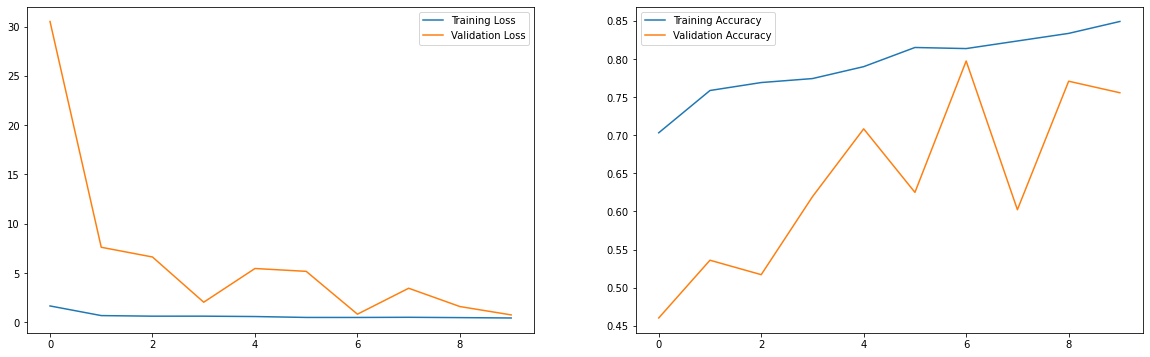

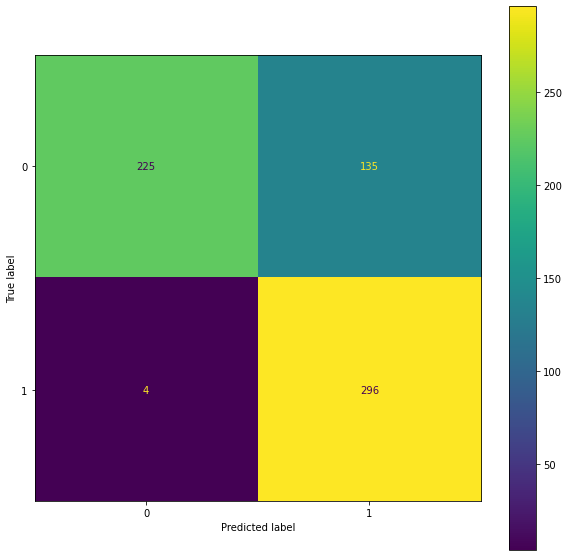

In [8]:
# Show results graphically
plot_training(history)
eval_model(resnet_2_model, test_x, test_y)

In [11]:
x = resnet_v2(inputs, [16,32], 1, 14) # Try initial hyperparamters on alternative network structure
resnet_3_model = keras.Model(inputs=inputs, outputs=output, name='resnet_3_model')
resnet_3_model.summary()

Model: "resnet_3_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 224, 224, 16) 64          conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 224, 224, 16) 0           batch_normalization_20[0][0]     
_____________________________________________________________________________________

Epoch 1/10
33/33 [==============================] - 184s 6s/step - loss: 0.6777 - accuracy: 0.7454 - val_loss: 8.3385 - val_accuracy: 0.4545
Epoch 2/10
33/33 [==============================] - 180s 5s/step - loss: 0.5500 - accuracy: 0.7828 - val_loss: 0.7626 - val_accuracy: 0.7727
Epoch 3/10
33/33 [==============================] - 182s 6s/step - loss: 0.4675 - accuracy: 0.8061 - val_loss: 0.8360 - val_accuracy: 0.6951
Epoch 4/10
33/33 [==============================] - 185s 6s/step - loss: 0.4530 - accuracy: 0.8236 - val_loss: 0.7256 - val_accuracy: 0.8068
Epoch 5/10
33/33 [==============================] - 184s 6s/step - loss: 0.4352 - accuracy: 0.8326 - val_loss: 1.1965 - val_accuracy: 0.6383
Epoch 6/10
33/33 [==============================] - 184s 6s/step - loss: 0.4145 - accuracy: 0.8378 - val_loss: 0.6223 - val_accuracy: 0.7784
Epoch 7/10
33/33 [==============================] - 182s 6s/step - loss: 0.4048 - accuracy: 0.8421 - val_loss: 0.6926 - val_accuracy: 0.7746
Epoch 8/10
33

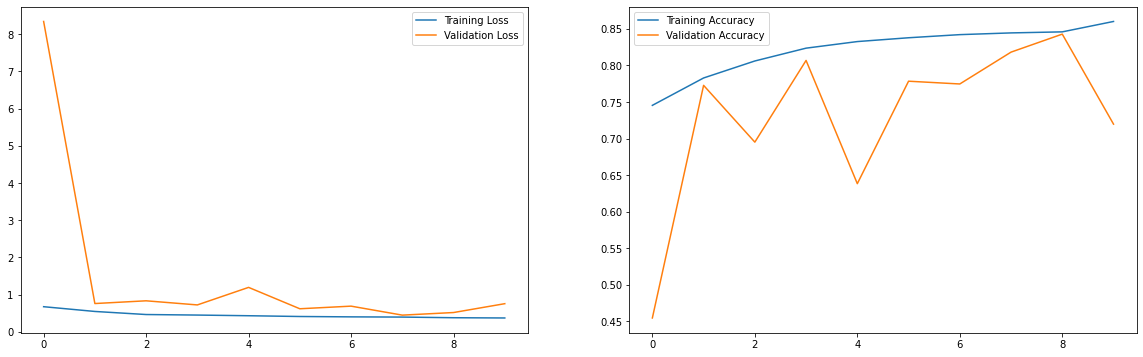

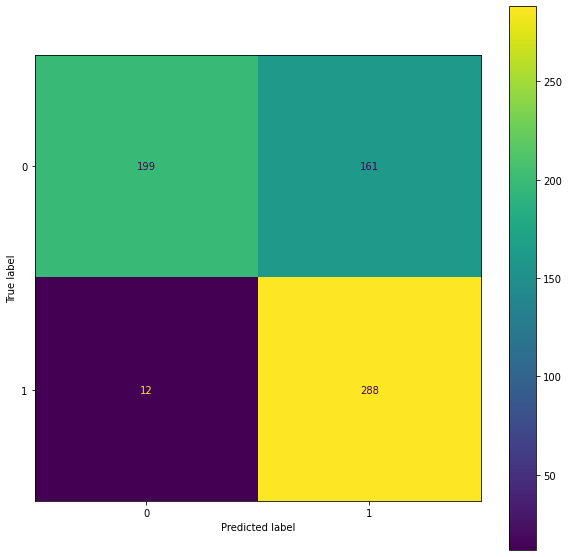

In [12]:
# Third trained model
resnet_3_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
history_3 = resnet_3_model.fit(train_x, train_y, batch_size=64, epochs=10, validation_split=0.2)

# Show results graphically
plot_training(history_3)
eval_model(resnet_3_model, test_x, test_y)

In [13]:
x = resnet_v2(inputs, [16,32,64], 2, 7) # Second hyperparameter variation on alternative model structure
resnet_4_model = keras.Model(inputs=inputs, outputs=output, name='resnet_4_model')
resnet_4_model.summary()

Model: "resnet_4_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 224, 224, 16) 64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 224, 224, 16) 0           batch_normalization_27[0][0]     
_____________________________________________________________________________________

Epoch 1/20
33/33 [==============================] - 406s 12s/step - loss: 1.1985 - accuracy: 0.7051 - val_loss: 6.5690 - val_accuracy: 0.4564
Epoch 2/20
33/33 [==============================] - 402s 12s/step - loss: 0.7955 - accuracy: 0.7629 - val_loss: 5.2416 - val_accuracy: 0.4659
Epoch 3/20
33/33 [==============================] - 401s 12s/step - loss: 0.7207 - accuracy: 0.7776 - val_loss: 1.2046 - val_accuracy: 0.7027
Epoch 4/20
33/33 [==============================] - 395s 12s/step - loss: 0.6667 - accuracy: 0.7871 - val_loss: 1.4920 - val_accuracy: 0.5947
Epoch 5/20
33/33 [==============================] - 396s 12s/step - loss: 0.6391 - accuracy: 0.8094 - val_loss: 0.7015 - val_accuracy: 0.7784
Epoch 6/20
33/33 [==============================] - 397s 12s/step - loss: 0.6217 - accuracy: 0.8156 - val_loss: 0.6319 - val_accuracy: 0.8049
Epoch 7/20
33/33 [==============================] - 391s 12s/step - loss: 0.6091 - accuracy: 0.8108 - val_loss: 0.8321 - val_accuracy: 0.7595
Epoch 

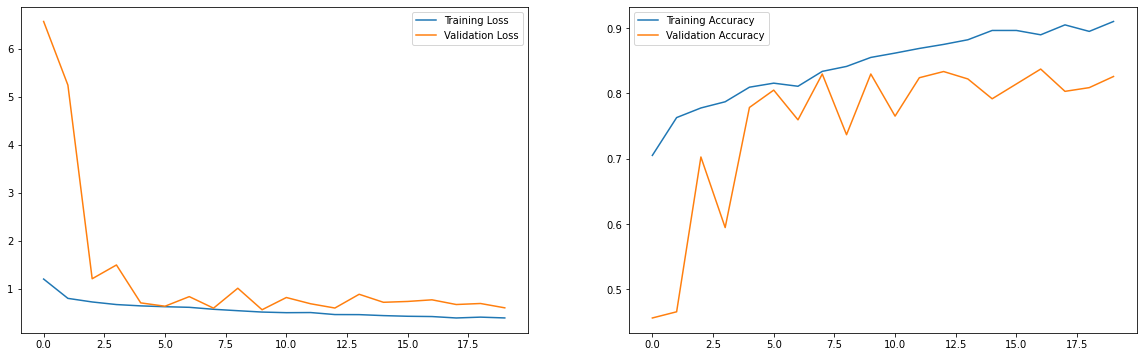

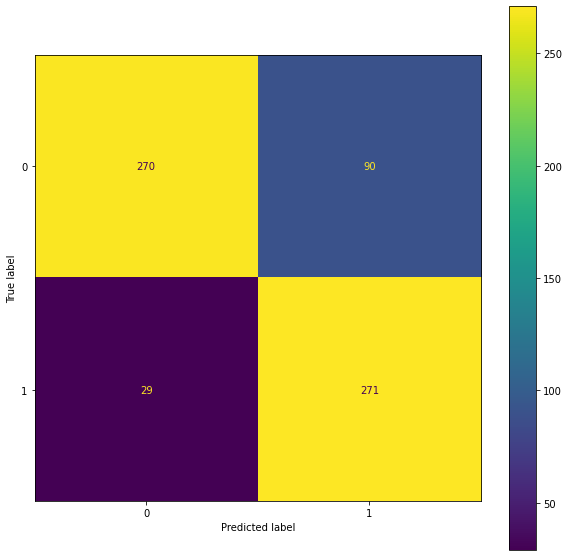

In [14]:
# Fourth trained model
resnet_4_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
history_4 = resnet_4_model.fit(train_x, train_y, batch_size=64, epochs=20, validation_split=0.2) # Double epochs to observe effect

# Show results graphically
plot_training(history_4)
eval_model(resnet_4_model, test_x, test_y)

In [15]:
x = resnet_v2(inputs, [32,64,128], 2, 14) # Increase filters, blocks and poolsize
resnet_5_model = keras.Model(inputs=inputs, outputs=output, name='resnet_5_model')
resnet_5_model.summary()

Model: "resnet_5_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 224, 224, 16) 64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 224, 224, 16) 0           batch_normalization_27[0][0]     
_____________________________________________________________________________________

Epoch 1/20
33/33 [==============================] - 394s 12s/step - loss: 0.4409 - accuracy: 0.8938 - val_loss: 0.6352 - val_accuracy: 0.8333
Epoch 2/20
33/33 [==============================] - 392s 12s/step - loss: 0.3760 - accuracy: 0.9090 - val_loss: 0.5630 - val_accuracy: 0.8523
Epoch 3/20
33/33 [==============================] - 397s 12s/step - loss: 0.3516 - accuracy: 0.9232 - val_loss: 0.7740 - val_accuracy: 0.8504
Epoch 4/20
33/33 [==============================] - 391s 12s/step - loss: 0.3467 - accuracy: 0.9222 - val_loss: 0.5825 - val_accuracy: 0.8504
Epoch 5/20
33/33 [==============================] - 389s 12s/step - loss: 0.3581 - accuracy: 0.9180 - val_loss: 0.6365 - val_accuracy: 0.8390
Epoch 6/20
33/33 [==============================] - 393s 12s/step - loss: 0.3371 - accuracy: 0.9260 - val_loss: 0.6114 - val_accuracy: 0.8485
Epoch 7/20
33/33 [==============================] - 395s 12s/step - loss: 0.3347 - accuracy: 0.9237 - val_loss: 0.7272 - val_accuracy: 0.8352
Epoch 

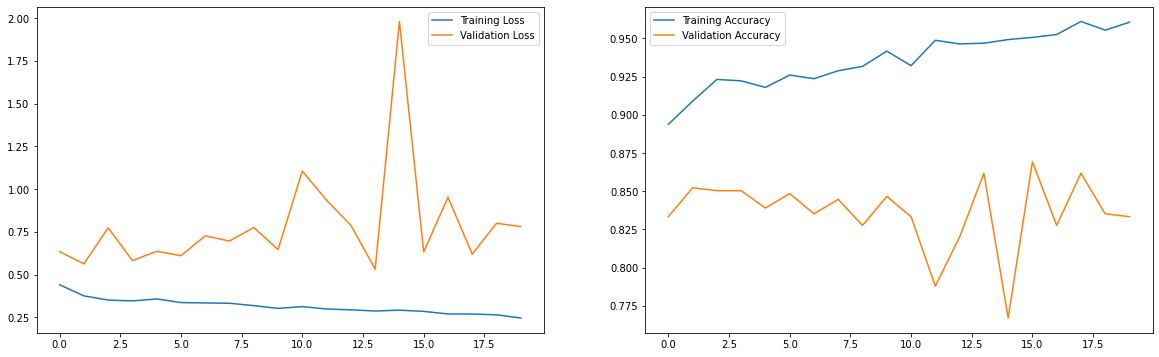

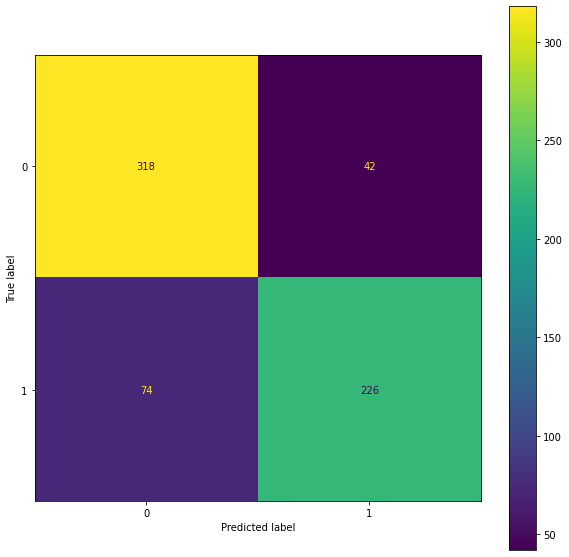

In [16]:
# Fifth trained model
resnet_5_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
history_5 = resnet_5_model.fit(train_x, train_y, batch_size=64, epochs=20, validation_split=0.2)

# Show results graphically
plot_training(history_5)
eval_model(resnet_5_model, test_x, test_y)

## Conclusion
### Fifth model had the best accuracy (82.42% on the test data, 94.88% on the training data), but only marginally (0.45% difference over Fourth model) and also significant number of benign tumors misclassified as malignant
### Fourth model showed a much less erratic loss/accuracy between then training and validation data which indicates less overfitting, and had a much better distribution of classification than the fifth model
### Overall, it can be argued that the fourth model is most optimal